# Part 3: Neural Networks for Neural Data of a single Participant

First we load the necessary libraries

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_recall_fscore_support

In [2]:
tf.random.set_seed(42)

Move EEGNet to external file, and see how to get it with git

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [4]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

### Exercise 1: 
Training the first neural network on patient 902

1. Load the .fif file that we used before. 
2. Extract the data and labels
3. As descibed in the lecture we need to normalize the data (**Tip**: Each trial seperately, and with the function normalize, given bellow)
4. We should use one-hot encoded labels, we can use the function '[to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)' from tensorflow.keras.utils

In [5]:
def normalize(volume):
    # input a single trial, of the shape (Channels) x (Time)
    stdev = np.std(volume, dtype=np.float64)
    mean = np.mean(volume, dtype=np.float64)
    return (volume - np.float32(mean)) / np.float32(stdev)

In [6]:
# solution
data_file = '902-P'
epochs = mne.read_epochs(data_file + '.fif', verbose='error')

data = epochs.get_data()
labels = np.where(epochs.events[:,-1] == 201, 0, 1)
labels = to_categorical(labels)
for i, sample in enumerate(data):
    data[i] = normalize(sample)

Convolutional neural networks have been traditionally used on images, with 3 dimensions: (X-axis) x (Y-axis) x (color channels). There we don't have multiple channels, which means we just expand the data in the last dimension such that the data shape then is (Channels) x (Time) x (1):

In [7]:
data = np.expand_dims(data, axis=-1)
print(data.shape)

(154, 60, 301, 1)


### Exercise 2:
Create the train and test data sets with the train_test_split as in 'Part 2: Machine Learning'

In [8]:
# solution
train_data, test_data, labels_train, labels_test = train_test_split(data, labels, 
                                                                    test_size=0.2, 
                                                                    random_state=42)


Now let's define the model, it takes as input : the number of classes, the number of recorded EEG channels and the number of time points per trial.

We are using EEGNet, which was developped by [Lawhern et. al. (2017)](https://github.com/vlawhern/arl-eegmodels)

### Exercise 3:
Define these three variables:

In [9]:
# solution
n_classes = 2
n_channels = data.shape[1]
n_timepoints = data.shape[2]

In [10]:
model = EEGNet(n_classes, n_channels, n_timepoints)

2022-03-25 14:30:06.850876: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 14:30:06.851368: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Before training we need to compile the network, there we specify the loss, optimizer, learning rate and any other metric that we would like to keep track of. 
We currently keep track of the accuracy and the AUC score, you are free to add anything else you find meaningfull. Check out https://www.tensorflow.org/api_docs/python/tf/keras/metrics for a list of possibilities. 

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', lr=0.01, metrics=['accuracy', 'AUC'])

Then we train the model for 50 epochs. We set the percentage of trials for the validation set with the variable validation_split (here 20%). 

In [12]:
history = model.fit(train_data, labels_train, validation_split=0.2, epochs=50)

Train on 98 samples, validate on 25 samples
Epoch 1/50
98/98 [==============================] - 3s 35ms/sample - loss: 0.8565 - accuracy: 0.4388 - AUC: 0.3831 - val_loss: 0.6889 - val_accuracy: 0.7200 - val_AUC: 0.7376
Epoch 2/50
98/98 [==============================] - 1s 8ms/sample - loss: 0.6521 - accuracy: 0.7449 - AUC: 0.7297 - val_loss: 0.6844 - val_accuracy: 0.8000 - val_AUC: 0.7488
Epoch 3/50
98/98 [==============================] - 1s 8ms/sample - loss: 0.6187 - accuracy: 0.7857 - AUC: 0.8199 - val_loss: 0.6800 - val_accuracy: 0.8000 - val_AUC: 0.7840
Epoch 4/50
98/98 [==============================] - 1s 9ms/sample - loss: 0.5959 - accuracy: 0.8163 - AUC: 0.8501 - val_loss: 0.6756 - val_accuracy: 0.8000 - val_AUC: 0.7840
Epoch 5/50
98/98 [==============================] - 1s 9ms/sample - loss: 0.5651 - accuracy: 0.8265 - AUC: 0.8532 - val_loss: 0.6712 - val_accuracy: 0.8000 - val_AUC: 0.8080
Epoch 6/50
98/98 [==============================] - 1s 9ms/sample - loss: 0.5582 - ac

98/98 [==============================] - 1s 9ms/sample - loss: 0.3059 - accuracy: 0.9082 - AUC: 0.9631 - val_loss: 0.5229 - val_accuracy: 0.8000 - val_AUC: 0.8352
Epoch 48/50
98/98 [==============================] - 1s 9ms/sample - loss: 0.3303 - accuracy: 0.8571 - AUC: 0.9593 - val_loss: 0.5297 - val_accuracy: 0.8000 - val_AUC: 0.8320
Epoch 49/50
98/98 [==============================] - 1s 8ms/sample - loss: 0.2978 - accuracy: 0.8980 - AUC: 0.9780 - val_loss: 0.5229 - val_accuracy: 0.8000 - val_AUC: 0.8336
Epoch 50/50
98/98 [==============================] - 1s 8ms/sample - loss: 0.2954 - accuracy: 0.9184 - AUC: 0.9721 - val_loss: 0.5054 - val_accuracy: 0.8000 - val_AUC: 0.8576


Let's evaluate how the learning of the model progressed during the training. The history variable contains the progresssion of the models evaluated on the metrics, that we gave to the model before as well as the loss. The history contains the vlues for the train and validation (called with a prefix of 'val_') metrics. We can see all that it keeps track of with:

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])

In [14]:
def plot_history(history, key):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_xlabel('Epochs')
    ax.set_ylabel(key.capitalize())

    plt.plot(history.history[key], color='C0', label = 'Train', linewidth=2)
    plt.plot(history.history['val_'+key], color='C3', label='Validation', linewidth=2)

    legend = ax.legend(fontsize='medium')
    ax.set_title('Model ' + key.capitalize())
    plt.show()

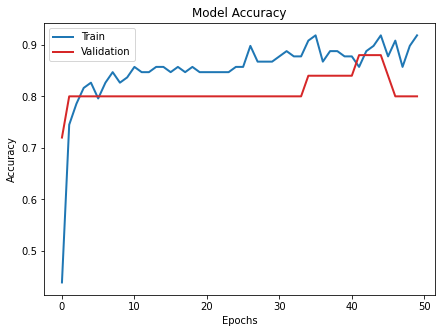

In [15]:
plot_history(history, 'accuracy')

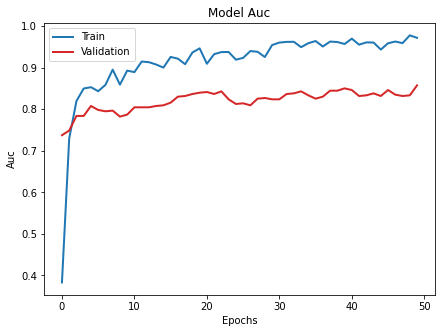

In [16]:
plot_history(history, 'AUC')

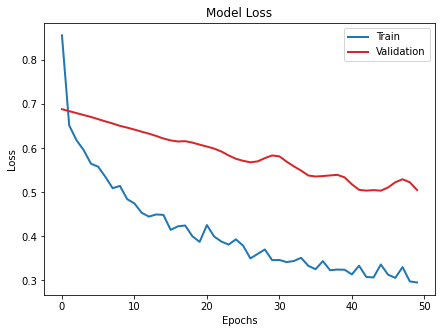

In [17]:
plot_history(history, 'loss')

Now we test the networks performance on the test set. We use the same function as in the previous notebook :

In [18]:
predictions = np.argmax(model.predict(test_data), axis=1)

print(predictions)
print(np.argmax(labels_test, axis=1))

f1_score(np.argmax(labels_test, axis=1), predictions)

[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1]


0.6

In [19]:
labels_test_true = np.argmax(labels_test, axis=1)
report_eegnet = classification_report(labels_test_true, predictions, target_names=['Standard', 'Novel'])
print('EEGNet Clasification Report:\n {}'.format(report_eegnet))

acc_eegnet = accuracy_score(labels_test_true, predictions)
print("Accuracy of EEGNet model: {}".format(acc_eegnet))

precision_eegnet,recall_eegnet,fscore_eegnet,support_eegnet=precision_recall_fscore_support(labels_test_true,
                                                                                predictions,
                                                                                average='macro')
print('Precision: {0}, Recall: {1}, f1-score:{2}'.format(precision_eegnet,recall_eegnet,fscore_eegnet))

EEGNet Clasification Report:
               precision    recall  f1-score   support

    Standard       0.89      0.96      0.92        25
       Novel       0.75      0.50      0.60         6

    accuracy                           0.87        31
   macro avg       0.82      0.73      0.76        31
weighted avg       0.86      0.87      0.86        31

Accuracy of EEGNet model: 0.8709677419354839
Precision: 0.8194444444444444, Recall: 0.73, f1-score:0.7615384615384615


How does this compare to the performance of the machine learning algorithms?

In [20]:
model = tf.keras.models.load_model('20210114-152824_fold_6.h5')
#losses = [(ActivationMaximization(model.layers[layer_idx], filter_indices), -1)]
#opt = Optimizer(model.input, losses, wrt_tensor=None, norm_grads=False)

In [21]:
ls

20210114-152824_fold_6.h5* Part 1.ipynb
902-P.fif                  Part 2.ipynb
AMLD_EPFL2022.key          Part_3_solutions.ipynb
Neural_Network_Test.fif    README.md


In [24]:
xx = np.load('Split_6.npz', allow_pickle=True)['data_test']
yy = np.load('Split_6.npz', allow_pickle=True)['labels_test']
xx = np.expand_dims(xx, axis=-1)
xx = normalize(xx)

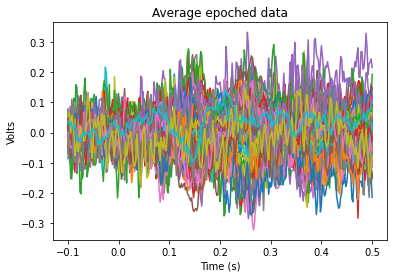

In [25]:
# solution
plt.plot(epochs.times, np.mean(xx[:,:,:,0], axis=0).T)
plt.title("Average epoched data")
plt.ylabel('Volts')
plt.xlabel('Time (s)')
plt.show()

In [26]:
import copy

In [27]:
ep_test_1 = copy.deepcopy(epochs)
ep_test_2 = copy.deepcopy(epochs)

ep_test_1._data = xx[:154,:,:,0]
ep_test_2._data[:115] = xx[154:,:,:,0]
ep_test_2 = ep_test_2.drop(np.arange(115, 154))

ep_test = mne.concatenate_epochs([ep_test_1, ep_test_2])
ep_test.events[:,-1] = yy

array([201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 202, 202, 202,
       202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202,
       202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201,
       201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 20

In [37]:
ep_test.event_id = {'Standard': 0, 'Novel': 1}

In [41]:
ep_test

Number of events,269
Events,Novel: 49Standard: 220
Time range,-0.100 – 0.500 sec
Baseline,-0.100 – 0.000 sec


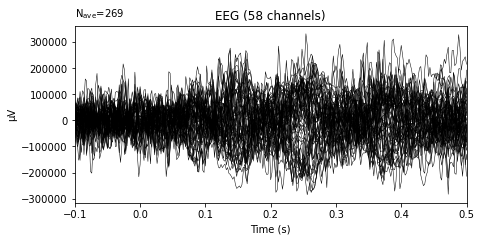

In [42]:
ep_test.average().plot();

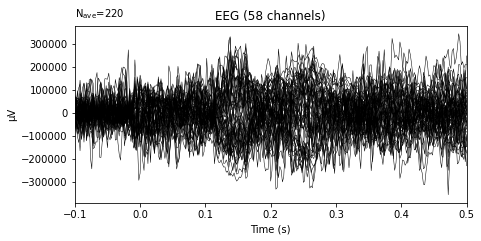

In [43]:
ep_test['Standard'].average().plot();

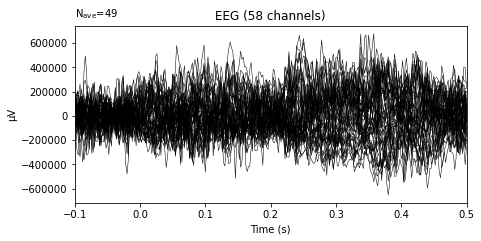

In [44]:
ep_test['Novel'].average().plot();

In [46]:
ep_test.save('Neural_Network_Test.fif', overwrite=True)

Overwriting existing file.


/var/folders/z4/zm423rsn5dv79lqw76znz1b80000gp/T/ipykernel_13855/1569766781.py:1: RuntimeWarning: This filename (Neural_Network_Test.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  ep_test.save('Neural_Network_Test.fif', overwrite=True)


In [49]:
# solution
data_file = 'Neural_Network_Test'
epochs = mne.read_epochs(data_file + '.fif', verbose='error')

data = epochs.get_data()
labels = to_categorical(labels)
for i, sample in enumerate(data):
    data[i] = normalize(sample)
data = np.expand_dims(data, axis=-1)



In [50]:
predictions = np.where(model.predict(data)>0.5, 1.0, 0.0)


f1_score(yy, predictions)

0.2608695652173913